In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
from aesara.tensor.subtensor import set_subtensor
import aesara.tensor as at

%load_ext lab_black
%load_ext watermark

# Prediction of time series

Adapted from [unit 10: sunspots.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit10/sunspots.odc).

Data can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/sunspots.txt).

Associated lecture video: Unit 10 Lesson 7

## Problem statement

Sunspot numbers observed each year from 1770 to 1869. 

BUGS Book Page 258.

In [3]:
y = np.loadtxt("../data/sunspots.txt")

In [4]:
y

array([100.8,  81.6,  66.5,  34.8,  30.6,   7. ,  19.8,  92.5, 154.4,
       125.9,  84.8,  68.1,  38.5,  22.8,  10.2,  24.1,  82.9, 132. ,
       130.9, 118.1,  89.9,  66.6,  60. ,  46.9,  41. ,  21.3,  16. ,
         6.4,   4.1,   6.8,  14.5,  34. ,  45. ,  43.1,  47.5,  42.2,
        28.1,  10.1,   8.1,   2.5,   0. ,   1.4,   5. ,  12.2,  13.9,
        35.4,  45.8,  41.1,  30.4,  23.9,  15.7,   6.6,   4. ,   1.8,
         8.5,  16.6,  36.3,  49.7,  62.5,  67. ,  71. ,  47.8,  27.5,
         8.5,  13.2,  56.9, 121.5, 138.3, 103.2,  85.8,  63.2,  36.8,
        24.2,  10.7,  15. ,  40.1,  61.5,  98.5, 124.3,  95.9,  66.5,
        64.5,  54.2,  39. ,  20.6,   6.7,   4.3,  22.8,  54.8,  93.8,
        95.7,  77.2,  59.1,  44. ,  47. ,  30.5,  16.3,   7.3,  37.3,
        73.9])

In [6]:
t = np.array(range(100))
yr = t + 1770  # where is the professor using this?

## Model 1

In [35]:
with pm.Model() as m1:
    eps_0 = pm.Normal("eps_0", 0, tau=0.0001)

    theta = pm.Normal("theta", 0, tau=0.0001)
    c = pm.Normal("c", 0, tau=0.0001)
    sigma = pm.Uniform("sigma", 0, 100)
    tau = 1 / (sigma**2)

    _m = c + theta * np.roll(y, shift=-1)[:-1]
    m = set_subtensor(_m[0], y[0] - eps_0)

    _eps = y - m
    eps = set_subtensor(_eps[0], eps_0)

    pm.Normal("likelihood", mu=m, tau=tau, observed=y[:-1])

    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_0, theta, c, sigma]
INFO:pymc:NUTS: [eps_0, theta, c, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 12 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 12 seconds.


In [36]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eps_0,0.077,21.726,-38.571,43.524,0.222,0.203,9621.0,7797.0,1.0
theta,0.817,0.060,0.709,0.932,0.001,0.000,7825.0,7267.0,1.0
c,8.506,3.528,1.995,15.239,0.040,0.028,7951.0,7430.0,1.0
sigma,21.966,1.626,19.051,25.030,0.017,0.012,9027.0,7453.0,1.0


## Model 1 using built in AR

docs are a little lacking here. will write up better instructions. how do you incorporate eps, or is it even necessary? I think eps is controlled by sigma, but why is it separate in the original BUGS model?

further reading:



- https://github.com/pymc-devs/pymc4/issues/198
- https://www.pymc-labs.io/blog-posts/bayesian-vector-autoregression/
- https://www.pymc.io/projects/examples/en/latest/time_series/AR.html
- https://discourse.pymc.io/t/vectorized-autoregressive-model/1449

In [54]:
with pm.Model() as m1_ar:
    rho = pm.Normal("rho", 0, tau=0.0001, shape=2)  # shape of rho determines AR order
    sigma = pm.Uniform("sigma", 0, 100)

    # constant=True means rho[0] is the constant term (c from BUGS model)
    pm.AR("likelihood", rho=rho, sigma=sigma, constant=True, observed=y)

    trace = pm.sample(3000, chains=4, cores=1)  # getting an error in multiprocessing

/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/pymc/distributions/timeseries.py:465: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
INFO:pymc:Sequential sampling (4 chains in 1 job)
NUTS: [rho, sigma]
INFO:pymc:NUTS: [rho, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.


In [55]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho[0],8.597,3.644,1.814,15.283,0.048,0.035,5720.0,5465.0,1.0
rho[1],0.810,0.061,0.702,0.928,0.001,0.001,5943.0,5972.0,1.0
sigma,21.795,1.605,18.972,24.943,0.019,0.014,6732.0,5947.0,1.0


In [46]:
y

array([100.8,  81.6,  66.5,  34.8,  30.6,   7. ,  19.8,  92.5, 154.4,
       125.9,  84.8,  68.1,  38.5,  22.8,  10.2,  24.1,  82.9, 132. ,
       130.9, 118.1,  89.9,  66.6,  60. ,  46.9,  41. ,  21.3,  16. ,
         6.4,   4.1,   6.8,  14.5,  34. ,  45. ,  43.1,  47.5,  42.2,
        28.1,  10.1,   8.1,   2.5,   0. ,   1.4,   5. ,  12.2,  13.9,
        35.4,  45.8,  41.1,  30.4,  23.9,  15.7,   6.6,   4. ,   1.8,
         8.5,  16.6,  36.3,  49.7,  62.5,  67. ,  71. ,  47.8,  27.5,
         8.5,  13.2,  56.9, 121.5, 138.3, 103.2,  85.8,  63.2,  36.8,
        24.2,  10.7,  15. ,  40.1,  61.5,  98.5, 124.3,  95.9,  66.5,
        64.5,  54.2,  39. ,  20.6,   6.7,   4.3,  22.8,  54.8,  93.8,
        95.7,  77.2,  59.1,  44. ,  47. ,  30.5,  16.3,   7.3,  37.3,
        73.9])

## Model 2: ARMA(2,1)

hold off on this for now - they are adding pm.ARMA this summer!

In [67]:
with pm.Model() as m2_ar:
    rho = pm.Normal("rho", 0, tau=0.0001, shape=3)  # shape of rho determines AR order
    sigma = pm.Uniform("sigma", 0, 100)

    # constant=True means rho[0] is the constant term (c from BUGS model)
    pm.AR("likelihood", rho=rho, sigma=sigma, constant=True, observed=y)

    trace = pm.sample(3000, chains=4, cores=1)  # getting an error in multiprocessing

    ppc = pm.sample_posterior_predictive(trace)

/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/pymc/distributions/timeseries.py:465: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
INFO:pymc:Sequential sampling (4 chains in 1 job)
NUTS: [rho, sigma]
INFO:pymc:NUTS: [rho, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 11 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.906, but should be close to 0.8. Try to increase the number of tuning steps.


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/aesara/compile/function/types.py", line 962, in __call__
    raise TypeError(
  File "/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/aesara/scan/op.py", line 1540, in rval
  File "/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/aesara/scan/op.py", line 1471, in p
    profile=profile,
  File "scan_perform.pyx", line 76, in aesara.scan.scan_perform.perform
TypeError: perform() takes exactly 27 positional arguments (26 given)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/pm/9z29qnf508bc1v6q8fksblm40000gn/T/ipykernel_54460/535758216.py", line 10, in <cell line: 1>
    ppc = pm.samp

In [68]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho[0],14.536,2.614,9.943,19.717,0.031,0.022,7117.0,6448.0,1.0
rho[1],1.404,0.074,1.271,1.549,0.001,0.001,6029.0,6403.0,1.0
rho[2],-0.711,0.074,-0.849,-0.574,0.001,0.001,5892.0,5901.0,1.0
sigma,15.520,1.132,13.453,17.689,0.013,0.009,7488.0,5981.0,1.0


/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/arviz/plots/tsplot.py:201: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


array([[<AxesSubplot:xlabel='likelihood_dim_0', ylabel='likelihood'>]],
      dtype=object)

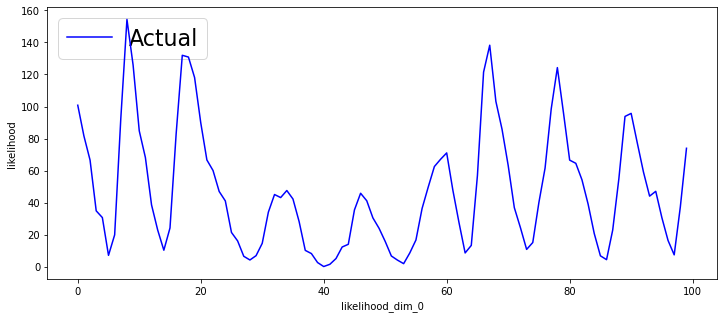

In [69]:
az.plot_ts(idata=trace, y="likelihood")